# Supplemental Figure 5

## Caption
Color at each location indicates the number of individual rivers with exceedance days above the threshold concentration for A) June, B) July, and C) August. 

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

### Standard imports
import numpy as np
import xarray as xr
import cmocean

### Matplotlib imports
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText

### Cartopy imports
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes

/Users/gloege/anaconda3/envs/cartopy/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


# Load data

see `_process_data.ipynb` to see how `exceedance_days_all_rivers_MJJA.nc` was created

In [2]:
### Define directories
dir_raw = '/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/raw/'
dir_clean = '/Users/gloege/Documents/Projects/MITgcm-Michigan-Phosphorus/data/clean/'

### Open datasets
ds_ed = xr.open_dataset(f'{dir_clean}exceedance_days_all_rivers_MJJA.nc')
ds_grid = xr.open_dataset(f'{dir_raw}grid_lake_michigan.nc')

### How many rivers are impacting each location?
* To calculate this I simply ask "are there any exceedance days at each location?"
* I then convert to an integer using `.astype(int)`. Alternatively, you could multiply 
the boolean by 1. You need to do this in order to add properly because `True+True=True`.
* Finally, I add all the rivers

In [3]:
ds_bool = (ds_ed > 0).astype(int)
ds_sum = ds_bool['Fox'] + \
        ds_bool['Grand'] + \
        ds_bool['Kalamazoo'] + \
        ds_bool['Manistee'] + \
        ds_bool['Manistique'] +\
        ds_bool['Menominee'] + \
        ds_bool['Milwaukee'] + \
        ds_bool['Muskegon'] + \
        ds_bool['PereMarquette'] + \
        ds_bool['Sheboygan'] + \
        ds_bool['StJoseph']

# Generate Figure

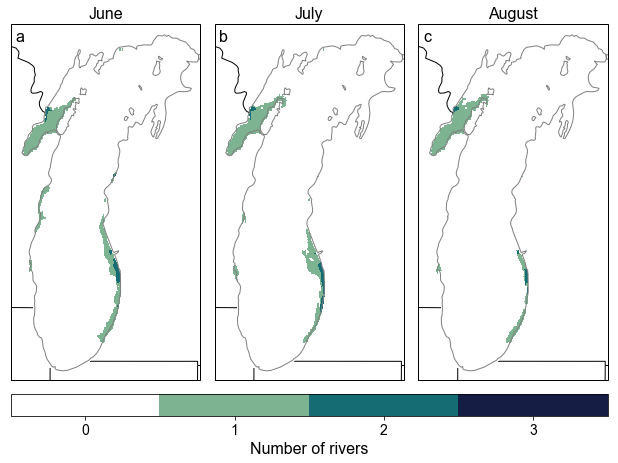

In [4]:
### ==============================================================
### Setup the grid
### if you have colorbar on the bottom it is best to have pad=0
### a smaller size and you have to explicitly set the 
### orientation=horizontal
### ==============================================================
fig = plt.figure(figsize=(11, 7.2))
projection = ccrs.Mercator()
axes_class = (GeoAxes, dict(map_projection=projection))
grid = AxesGrid(fig, 111, 
                axes_class = axes_class,
                share_all=False,
                nrows_ncols = (1, 3),
                axes_pad = 0.2,
                cbar_location = 'bottom',
                cbar_mode = 'single',
                cbar_pad = 0,
                cbar_size = '2%',
                label_mode = '')  # note the empty label_mode

### ==============================================================
### Need to set projection of ticks 
### to make labeling work
### Really hacky way to make labels work 
### with AxesGrid-GeoAxes
### ==============================================================
for ax in grid:
    ax.set_xticks(ax.get_xticks(),crs=projection)
    ax.set_yticks(ax.get_yticks(),crs=projection)

### ==============================================================
### Set titles
### ==============================================================
grid[0].set_title('June', fontsize=16)
grid[1].set_title('July', fontsize=16)
grid[2].set_title('August', fontsize=16)

### ==============================================================
### Set boundary of the map
### This defines Lake Michigan
### ==============================================================
for ax in grid:
    ax.set_extent([-84.75, -88.25, 41.5, 46.25]) ### Michigan

### ==============================================================
### Create a feature for States/Admin 1 
### regions at 1:50m from Natural Earth
### ==============================================================
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
for ax in grid:
    ax.add_feature(states_provinces, 
                   edgecolor='black', 
                   facecolor='none', 
                   zorder=1)

### ==============================================================
### Create a feature for lakes at 1:50m from Natural Earth
### ==============================================================
lakes_50m = cfeature.NaturalEarthFeature(
    category='physical',
    name='lakes',
    scale='10m',
    facecolor='none')
for ax in grid:
    ax.add_feature(lakes_50m, 
                   edgecolor=(0.5,0.5,0.5), 
                   facecolor='none', 
                   zorder=2)
    
### ==============================================================
### Define a colormap
### ==============================================================
vmin, vmax = -0.5, 3.5
cmap = cmocean.cm.tempo
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1,1,1,1.0)
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(vmin,vmax,5)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

### ==============================================================
### Loop over grid positions and color each subplot
### Month vector used to switch each month
### ==============================================================
month = ['june', 'july', 'august']
for pos in [0,1,2]:
    sub = grid[pos].pcolormesh(ds_sum['X'].values, 
                    ds_sum['Y'].values, 
                    np.ma.masked_array(ds_sum.
                       where(ds_sum['month']==month[pos], drop=True).
                       squeeze().
                       values,
                        mask=(ds_grid['Depth'].values==0)),
                    cmap = cmap, 
                    norm = norm,
                    vmin = vmin, 
                    vmax = vmax,
                    transform=ccrs.PlateCarree(),
                    zorder = 2)

### ==============================================================
### Add colorbar
### Better to use plt with reference to cax 
### than to grid.cbar_axes[0].colorbar(sub)
### since it is clunky as all get
### ==============================================================
cbar = plt.colorbar(sub, cax=grid.cbar_axes[0], orientation='horizontal')
cbar.set_label(r'Number of rivers', fontsize=16)
cbar.set_ticks(np.arange(0, 4, 1))
cbar.ax.tick_params(labelsize=14) 

### ==============================================================
### Subplot labels
### ==============================================================
label_a = AnchoredText("a", loc=2, prop=dict(size=16), frameon=False, pad=0.3, borderpad=0)
label_b = AnchoredText("b", loc=2, prop=dict(size=16), frameon=False, pad=0.3, borderpad=0)
label_c = AnchoredText("c", loc=2, prop=dict(size=16), frameon=False, pad=0.3, borderpad=0)
grid[0].add_artist(label_a)
grid[1].add_artist(label_b)
grid[2].add_artist(label_c)